In [1]:
import copy
import glob
import os
import pickle
import numpy as np
import cv2
import g2o
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("../..")

from mapper.geometry import from_twist, to_twist
from mapper.common import Capture
from mapper.keypoints import extract_keypoints, match

In [2]:
def get_frame(cap):
    """Reads and undistorts next frame from stream."""
    frame, _, frame_name, _ = cap.get_next_frame(
        preprocess=True, undistort=True, equalize_hist=True)
    return frame, frame_name

In [3]:
camera_matrix = pickle.load(open("../../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

frames_root = "../../data_processing/splitted"
frame_files = sorted(glob.glob(os.path.join(frames_root, "radiometric", "*.tiff")))
frame_files = frame_files[117:]  # starting from 100 + 16 initialization frames
cap = Capture(frame_files, None, camera_matrix, dist_coeffs)

pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create(nfeatures=5000, fastThreshold=12)
match_max_distance = 20.0

frames = []
frame_names = []
for _ in range(50):
    frame, frame_name = get_frame(cap)
    frames.append(frame)
    frame_names.append(frame_name)

In [4]:
def estimate_camera_pose_pnp(img_points, pts_3d, camera_matrix, prev_pose):
    """Estimates the camera world pose of a frame based on 2D-3D
    corresponding points.

    Args:
        img_points (`numpy.ndarray`): A set of keypoints extracted from the
            current frame. Shape (-1, 1, 2). These keypoints can also be tracked
            from the previous frame.

        pts_3d (`numpy.ndarray`): Triangulated 3D points corresponding to
            the keypoints in img_points. Shape (-1, 1, 3). Note, that the order
            of the points in this array needs to be consistent with the order of
            keypoints in img_points.

        camera_matrix (`numpy.ndarray`): Camera matrix of the camera which
            was used to acquire frames.

    Returns:
        R (`numpy.ndarray`): Rotation matrix of the camera coordinate system
            w.r.t. world coordinate system. Shape (3, 3).
        t (`numpy.ndarray`): Translation (x, y, z) of the camera coordinate
            system w.r.t. world coordinate system. Shape (3,).

    Note:
        This function assumes keypoints to be extracted from an undistorted
        frame.
    """
    print("size of points in estimate_camera_pose", img_points.shape, pts_3d.shape)
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts_3d.reshape(-1, 1, 3),
        img_points.reshape(-1, 1, 2),
        camera_matrix,
        None,
        rvec=prev_pose[:3].reshape(3, 1),
        tvec=prev_pose[3:].reshape(3, 1),
        useExtrinsicGuess=True,
        reprojectionError=1,
        iterationsCount=1000,
        flags=cv2.SOLVEPNP_ITERATIVE)
    if not success:
        raise RuntimeError("Could not compute the camera pose for the new frame with solvePnP.")
    print("solvePnP success", success)
    print("solvePnP inliers", inliers.shape)
    R = cv2.Rodrigues(rvec)[0].T
    t = -np.matmul(cv2.Rodrigues(rvec)[0].T, tvec)
    return R, t


def get_map_points_and_img_points_for_matches(last_kf_index, matches, current_kp):
    """Returns map points and corresponding image points for current frame.

    Given matches between a current frame and the last keyframe the function
    finds which key point in the current frame correpsonds to which key point
    in the last key frame and returns the map points correpsodning to these
    key points. these can be used for solvePnP to get a first pose estimate of
    the current frame.
    """
    # get all map points observed in last KF
    _, pts_3d, associated_kp_indices, _ = map_points.get_by_observation(last_kf_index)  # get all map points observed by last KF
    # get indices of map points which were found again in the current frame
    kp_idxs = []
    new_matches = []
    for m in matches:
        try:
            kp_idx = associated_kp_indices.index(m.queryIdx)
        except ValueError:
            pass
        else:
            kp_idxs.append(kp_idx)
            new_matches.append(m)
    print("{} of {} ({:3.3f} %) keypoints in last key frame have been found again in current frame".format(len(new_matches), len(matches), len(new_matches)/len(matches)))
    # get map points according to the indices
    pts_3d = pts_3d[np.array(kp_idxs), :]
    # get corresponding key points in the current frame
    img_points = np.array([current_kp[m.trainIdx].pt for m in new_matches]).reshape(-1, 1, 2)
    return pts_3d, img_points

In [5]:
current_frame = frames[0]

current_kp, current_des = extract_keypoints(current_frame, orb)
prev_node_id = sorted(pose_graph.nodes)[-1]
matches, last_pts, current_pts, match_frame = match(bf,
    pose_graph.nodes[prev_node_id]["frame"],
    current_frame,
    pose_graph.nodes[prev_node_id]["des"],
    current_des, cv2.KeyPoint_convert(pose_graph.nodes[prev_node_id]["kp"].reshape(-1, 1, 2)),
    current_kp, match_max_distance, draw=True)

# get the map points and corresponding key points in last KF
pts_3d, img_points = get_map_points_and_img_points_for_matches(
    prev_node_id, matches, current_kp)

# recover initial camera pose of current frame by solving PnP
prev_pose = np.copy(pose_graph.nodes[prev_node_id]["pose"])
print("previous pose: ", from_twist(prev_pose))
R_current, t_current = estimate_camera_pose_pnp(img_points, pts_3d, camera_matrix, prev_pose)
current_pose = to_twist(R_current, t_current)
print("current pose: ", R_current, t_current)

assert np.allclose(np.linalg.det(R_current), 1.0), "Determinant of rotation matrix in local tracking is not 1."

Found 572 matches of current frame with last key frame
207 of 572 (0.362 %) keypoints in last key frame have been found again in current frame
previous pose:  (array([[ 0.99982804, -0.01250102, -0.0136974 ],
       [ 0.01276745,  0.99972757,  0.01953894],
       [ 0.01344941, -0.01971046,  0.99971527]]), array([[-1.73820058],
       [ 0.53205585],
       [-0.75361427]]))
size of points in estimate_camera_pose (207, 1, 2) (207, 3)
solvePnP success True
solvePnP inliers (87, 1)
current pose:  [[ 0.99994381 -0.01012829  0.00312855]
 [ 0.01009987  0.99990877  0.00896859]
 [-0.0032191  -0.00893649  0.99995489]] [[-0.69528876]
 [ 0.49772497]
 [-0.50219095]]


### Perform pose optimization with g2o instead

In [ ]:
# advance frame pose with constant motion model
# find matches with previous frame

# project local map
# search for more matches in local map

# run pose optimization

In [7]:
map_points.observations

[{0: 2843, 1: 2797},
 {0: 2963, 1: 2900},
 {0: 3916, 1: 4237},
 {0: 709, 1: 323},
 {0: 2634, 1: 2278},
 {0: 3004, 1: 2939},
 {0: 3436, 1: 3525},
 {0: 3450, 1: 2961},
 {0: 3820, 1: 4038},
 {0: 514, 1: 1750},
 {0: 1521, 1: 1315},
 {0: 1829, 1: 1781},
 {0: 2162, 1: 2050},
 {0: 3142, 1: 3075},
 {0: 3469, 1: 3559},
 {0: 3652, 1: 3872},
 {0: 3675, 1: 3897},
 {0: 3910, 1: 4226},
 {0: 4125, 1: 4510},
 {0: 673, 1: 393},
 {0: 690, 1: 373},
 {0: 1507, 1: 475},
 {0: 2834, 1: 2789},
 {0: 2839, 1: 2794},
 {0: 2891, 1: 2842},
 {0: 2992, 1: 2922},
 {0: 3931, 1: 4247},
 {0: 4092, 1: 4479},
 {0: 143, 1: 306},
 {0: 675, 1: 401},
 {0: 1397, 1: 1200},
 {0: 2851, 1: 2805},
 {0: 3039, 1: 2970},
 {0: 3424, 1: 3515},
 {0: 3620, 1: 3846},
 {0: 3690, 1: 3909},
 {0: 3902, 1: 4216},
 {0: 4127, 1: 4513},
 {0: 197, 1: 74},
 {0: 289, 1: 828},
 {0: 627, 1: 473},
 {0: 693, 1: 294},
 {0: 762, 1: 1780},
 {0: 1128, 1: 1730},
 {0: 2238, 1: 2113},
 {0: 2496, 1: 2477},
 {0: 2790, 1: 2747},
 {0: 2793, 1: 2748},
 {0: 2794, 1: 

In [ ]:
# just for copying the code...
def local_bundle_adjustment(map_points, pose_graph, camera_matrix):
    """Perform local bundle adjustment with local map and local keyframes."""
    newest_node_id = list(sorted(pose_graph.nodes))[-1]
    neighbors_keyframes = get_neighbors(pose_graph, newest_node_id)
    nodes = [*neighbors_keyframes, newest_node_id]
    print("Bundle adjustment for keyframe {}".format(newest_node_id))
    print("Neighboring keyframes: {}".format(neighbors_keyframes))
    # set robust kernel to 95 % confidence interval of local map
    map_points_local = get_local_map(map_points, neighbors_keyframes)
    robust_kernel_value = 1.96*np.std(map_points_local.pts_3d)
    # perform local bundle adjustment
    bundle_adjust(pose_graph, map_points, nodes, camera_matrix,
        robust_kernel_value)

In [ ]:
pose_graph

In [8]:
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

# add current frame pose vertex
R, t = from_twist(prev_pose)  # later put here the estimate from constant velocity model
pose = g2o.SE3Quat(R.T, np.squeeze(-R.T.dot(t)))
v_se3 = g2o.VertexSE3Expmap()
v_se3.set_estimate(pose)
v_se3.set_id(0)
v_se3.set_fixed(False)
optimizer.add_vertex(v_se3)

# add map point vertices & edges
nodes = []
point_id = len(pose_graph)
inliers = dict()
for i, (point, observation) in enumerate(
        zip(map_points.pts_3d, map_points.observations)):

    # skip points not visible in the selected subset of key frames
    if not any([node_id in nodes for node_id in observation.keys()]):
        continue

    edge = g2o.EdgeSE3ProjectXYZOnlyPose()


NameError: name 'nodes' is not defined

In [ ]:
nodes = 

In [6]:
# --> result is pretty off

### TODO:

1) Set extrinisc guess to previous pose
2) Run solvePnP

1) Use constant velocity model to predict current pose
2) Project points seen in last frame into current frame using its predictied pose
3) Perform pose optimization with motion-only BA

In [36]:
[from_twist(pose_graph.nodes[n]["pose"]) for n in pose_graph]

[(array([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
  array([[0.],
         [0.],
         [0.]])),
 (array([[ 0.99992074,  0.01085902, -0.00637213],
         [-0.01088013,  0.99993541, -0.0032866 ],
         [ 0.00633603,  0.00335567,  0.9999743 ]]),
  array([[ 0.73991763],
         [-0.59673299],
         [ 0.4595001 ]]))]

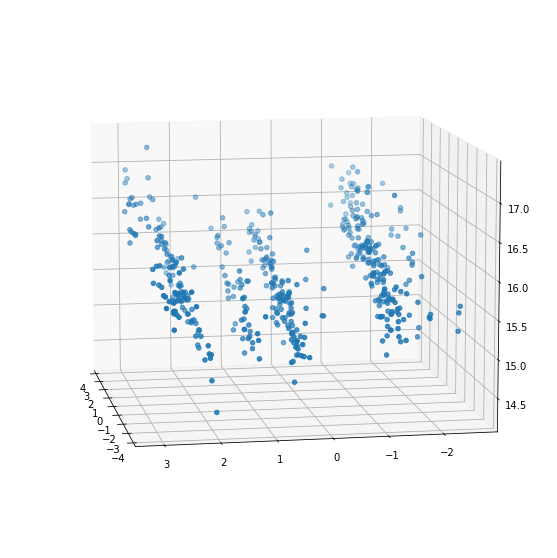

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points.pts_3d[:, 0], map_points.pts_3d[:, 1], map_points.pts_3d[:, 2])
ax.view_init(elev=10., azim=170)
plt.show()